## 3. Octave and one-third octave band filters

In this notebook we'll go through designing and appyling **fractional band-pass filtering** (mainly 1/1 and 1/3 octave filters) to our already processed signal.

Once we have applied a **frequency weighting filter to the signal** we can obtain a measure of the **global sound pressure level for a certain time interval of interest**. That's nice but, if we want to have **information as to the frequencies in which the measured signal has a high SPL** we need to split this global level in a per-frequency-band indicator.

For that, we will **apply band-pass filters to our signal**. The amount of pass-bands filters to apply will be determined by how many different frequency bands we'd like our measurement to be split in. We will explore **1/1 octave and 1/3 octave filters**, increasing three times the amount of bands for the latter.

## Filter specifications

The band-pass filters used for acoustical measurements are defined by the **IEC 61260 standard**. In it, the **templates that these filters should follow are specified**. The requirements are given in **two Class based on their performance: Class 1 and Class 2**. Both have the **same design objectives but they different in the acceptance limit**. 

Since the filters are defined on a logarithmic scale, **all filters of the same family should have the same response**. So, only one response is specified with the **mid-band frequency normalized to 1**.

For each of the filters, the **exact mid-band frequency** can be determined from the following expression: 

$$ f_m = f_rG^{x/b}, \ \text{when b is odd} $$

$$ f_m = f_rG^{(2x+1)/b}, \ \text{when b is even} $$

Where $ f_r $ is the **reference frequency**, $ G = 10^{0.3} $ is the **octave frequency ratio** (that represents the distance between frequencies that is equal to an octave band), and $ 1/b $ is the **bandwidth designator** (1/1 for octave and 1/3 for third-octave bands, and so on).

Next, we'll bring over these variables that will allow us to visualize and build our filters.

In [1]:
import numpy as np

# Reference frequency
FR = 1000.0

# Sampling frequency
FS = 48000

# Octave frequency ratio
G = 10**(3/10)

# Exact third-octave mid-band frequencies
fto_mid = np.array([FR*G**(x/3) for x in np.arange(33)-19])

# Exact octave band mid-band frequencies
foct_mid = np.array([FR*G**(x) for x in np.arange(11)-6])

# Nominal third-octave mid-band frequencies
fto_nom = np.array([ 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 50.0, 63.0, 80.0, 100.0, 
                    125.0, 160.0, 200.0, 250.0, 315.0, 400.0, 500.0, 630.0, 800.0, 
                    1000.0, 1250.0, 1600.0, 2000.0, 2500.0, 3150.0, 4000.0, 5000.0,
                    6300.0, 8000.0, 10000.0, 12500.0, 16000.0, 20000.0])

# Nominal octave band mid-band frequencies
foct_nom = fto_nom[1::3]

Great! Now we have both the **nominal and exact mid-band frequencies for both the octave and third-octave frequency filters between 16 Hz and 20,000 Hz**. 

## Plotting the filter templates

Before moving on to calculating the **upper and lower boundary frequencies**, we'll get the standard's specification for designing the filters and **plot the templates for the Class 1 octave and third-octave band-pass filters**.

(0.5, 2)

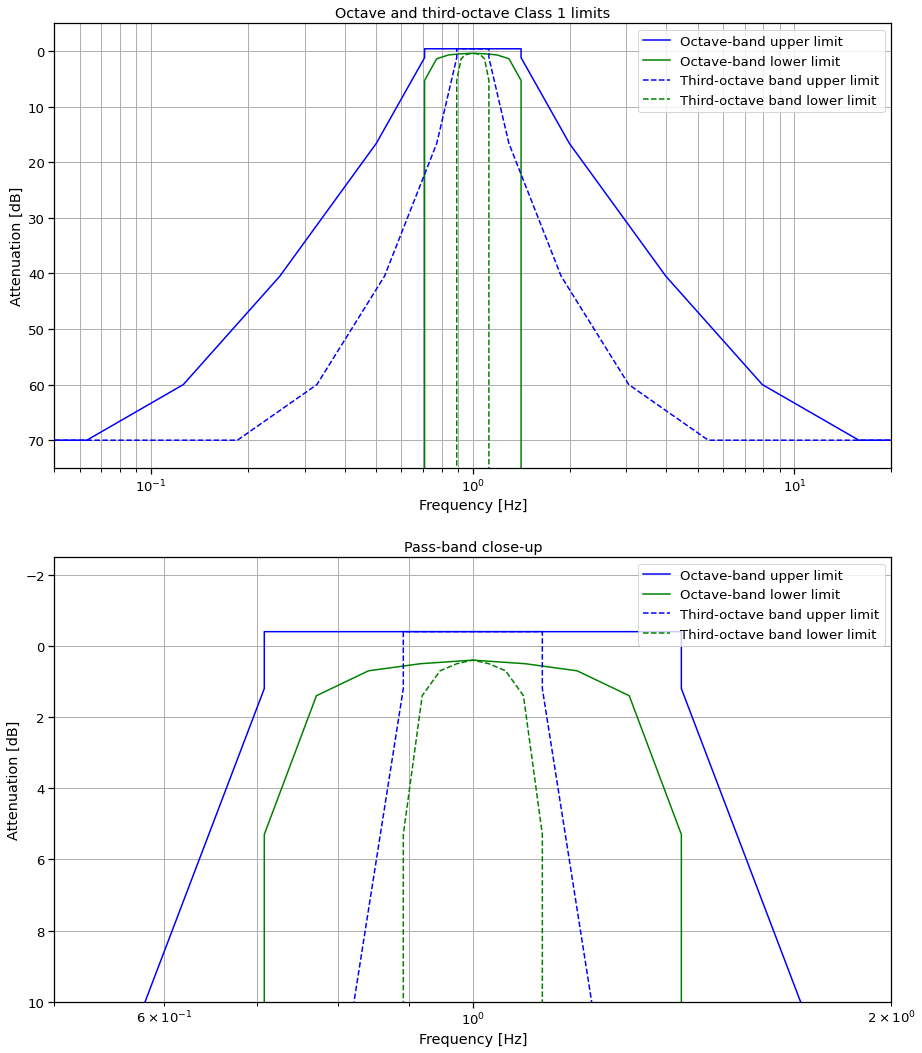

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

# minimum absolute representable float
eps = np.finfo(float).eps

# a very big number
inf = 10**5

# Standard definitions
# - - - - - - - - - - - - - - - 

# Octave-band frequency array
x_t_oct = np.array([-inf, G**-4, G**-3, G**-2, 
                    G**-1, G**(-1/2-eps), G**(-1/2+eps),
                    G**(-3/8), G**(-1/4), G**(-1/8),
                    1, G**(1/8), G**(1/4), G**(3/8),
                    G**(1/2-eps), G**(1/2+eps), G**1,
                    G**2, G**3, G**4, inf])

# Third-octave band frequency array
x_t_to = np.array([-inf, 0.18546, 0.32748, 0.53143, 0.77257, 
                   0.89125-eps, 0.89125+eps, 0.91958, 0.94719, 
                   0.97402, 1, 1.02667, 1.05575, 1.08746, 
                   1.12202-eps, 1.12202+eps, 1.29437, 
                    1.88173, 3.05365, 5.39195, inf])

# Class 1 upper tolerance
y_upp = np.array([70, 70, 60, 40.5, 16.6, 1.2, -0.4, -0.4, 
                  -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, 
                  -0.4, 1.2, 16.6, 40.5, 60, 70, 70])

# Class 1 lower tolerance
y_low = np.array([inf, inf, inf, inf, inf, inf, 5.3, 1.4,
                  0.7, 0.5, 0.4, 0.5, 0.7, 1.4, 5.3, 
                  inf, inf, inf, inf, inf, inf])

# Plotting
# - - - - - - - - - - - - - - - 

fig, ax = plt.subplots(2, 1, figsize=(15,18))

for ax_ in ax:
    ax_.plot(x_t_oct, y_upp, c='b', label='Octave-band upper limit')
    ax_.plot(x_t_oct, y_low, c='g', label='Octave-band lower limit')
    ax_.plot(x_t_to, y_upp, '--', c='b', label='Third-octave band upper limit')
    ax_.plot(x_t_to, y_low, '--', c='g', label='Third-octave band lower limit')
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Frequency [Hz]')
    ax_.set_ylabel('Attenuation [dB]')
    
ax[0].set_title('Octave and third-octave Class 1 limits')
ax[1].set_title('Pass-band close-up')

ax[0].set_ylim([75, -5])
ax[0].set_xlim([5*10**-2, 20])

ax[1].set_ylim([10, -2.5])
ax[1].set_xlim([5*10**-1, 2])

Having our **Class 1 templates for all of the filters belonging to the families of octave and third-octave band-pass filters** we only need to, well desing our filters!

## Designing the filters

For that, we need the **upper and lower edge-band frequencies for each filter** which can be calculated respectively with the equations below:

$$ f_1 = f_mG^{-1/(2b)} $$
$$ f_2 = f_mG^{+1/(2b)} $$

By means of the `butter` function and based on these frequencies we can get the **coefficients for a second-order-section implementation of a IIR Butterworth filter**. The **Butterworth filters** offer the advantage of having a **frequency response as flat as possible in the passband**.

Next, we'll compute the edge-band frequencies and then build a **function based on** `butter` **that will yield these coefficients for each of the pass-band filters**, `but_bp`.

In [3]:
from scipy.signal import butter

# Octave-band upper and lower frequencies
foct_1 = foct_mid*G**(-1/2)
foct_2 = foct_mid*G**(1/2)

# Third octave-band upper and lower frequencies
fto_1 = fto_mid*G**(-1/(2*3))
fto_2 = fto_mid*G**(1/(2*3))

def sos_bp(low, upp, fs=FS, order=4):
    """ Returns the coefficients to a second-order-section 
    Butterworth band-pass filter. The filter is built with 
    'order' orders and according to the upper and lower 
    edge-band frequencies ('low' and 'up'). """
    nyq = 0.5*fs
    f1 = low/nyq
    f2 = upp/nyq
    sos = butter(order, [f1, f2], btype='band', output='sos')
    return sos

## Filter application

Having our **edge-band frequencies** for the **octave and third-octave bands between 16 Hz and 20,000 Hz**, we will define a new function called `bp_filt` that will **compute and apply the filter to the input signal**. This will be based on the function defined before and `scipy`'s `sosfilt`that filters the input signal `'x'` based on the given coefficients.

To test this funcction we'll load again the **field recording audio and filter it in the 4 kHz band both with and octave and third-octave filter**.

In [4]:
import ipywidgets
import IPython
from scipy.signal import sosfilt
from scipy.io import wavfile 

# load audio
fs, field = wavfile.read('../aud/field.wav')

# limiting audio length to 5 seconds
T_LEN = 5
start = np.random.randint(len(field)-(fs*T_LEN))
end = start + fs*T_LEN
x = field[start:end]

# function definition
def bp_filt(x, low, upp, fs=FS, order=4):
    """ Applies a second-order-section band-pass filter 
    to the input signal 'x'.
    'low' and 'upp', the upper and lower edge-band frequencies
    must be specified. """
    sos = sos_bp(low, upp, fs=fs, order=order)
    return sosfilt(sos, x)

# 4 kHz octave band index
oct_idx = np.argmin(np.abs(foct_mid - 4000))
# 4 kHz third-octave band index
to_idx = np.argmin(np.abs(fto_mid - 4000))

x_oct = bp_filt(x, foct_1[oct_idx], foct_2[oct_idx])
x_to = bp_filt(x, fto_1[to_idx], fto_2[to_idx])

# creating widgets
rec_oct = IPython.display.Audio(x_oct, rate=fs)
rec_to = IPython.display.Audio(x_to, rate=fs)

# displaying
print('4 kHz Octave filter')
IPython.display.display(rec_oct)
print('4 kHz Third-octave filter')
IPython.display.display(rec_to)

4 kHz Octave filter


4 kHz Third-octave filter


## Plotting the octave filter bank

Different filters indeed! Next, as an example, we'll show the complete **octave filter bank**, for the stated frequencies.

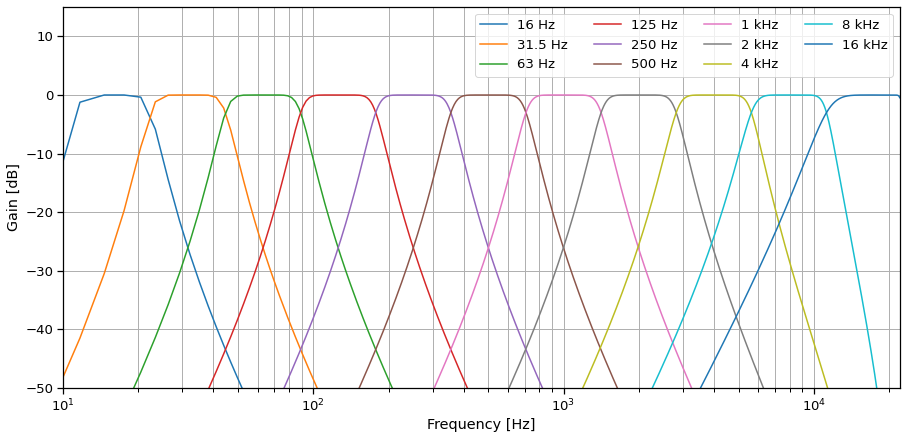

In [5]:
from scipy.signal import sosfreqz

# Nominal octave mid-band frequencies
foct_nom_str = ['16 Hz', '31.5 Hz','63 Hz',  '125 Hz','250 Hz', 
                '500 Hz','1 kHz', '2 kHz', '4 kHz', '8 kHz', 
                '16 kHz']
# Plotting
fig, ax = plt.subplots(figsize=(15,7))

for nom, low, upp in zip(foct_nom_str, foct_1, foct_2):
    # Computing the filter
    sos = sos_bp(low, upp)
    # Getting the response
    w, h = sosfreqz(sos, worN=2**13)
  
    # Plotting
    ax.plot((FS*0.5/np.pi)*w, 20*np.log10(abs(h+eps)), label=nom)

ax.set_xscale('log')
ax.grid('on', which='both')
ax.legend(ncol=4)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Gain [dB]')
ax.set_xlim([10, 22000])
ax.set_ylim([-50, 15]);

## Filter response validation

Finally, we'll **validate the response of our octave and third-octave frequency filters**. To do this we'll choose the 1 kHz frequency for both as an example, and **compare it to the Class 1 standard's filter template**.

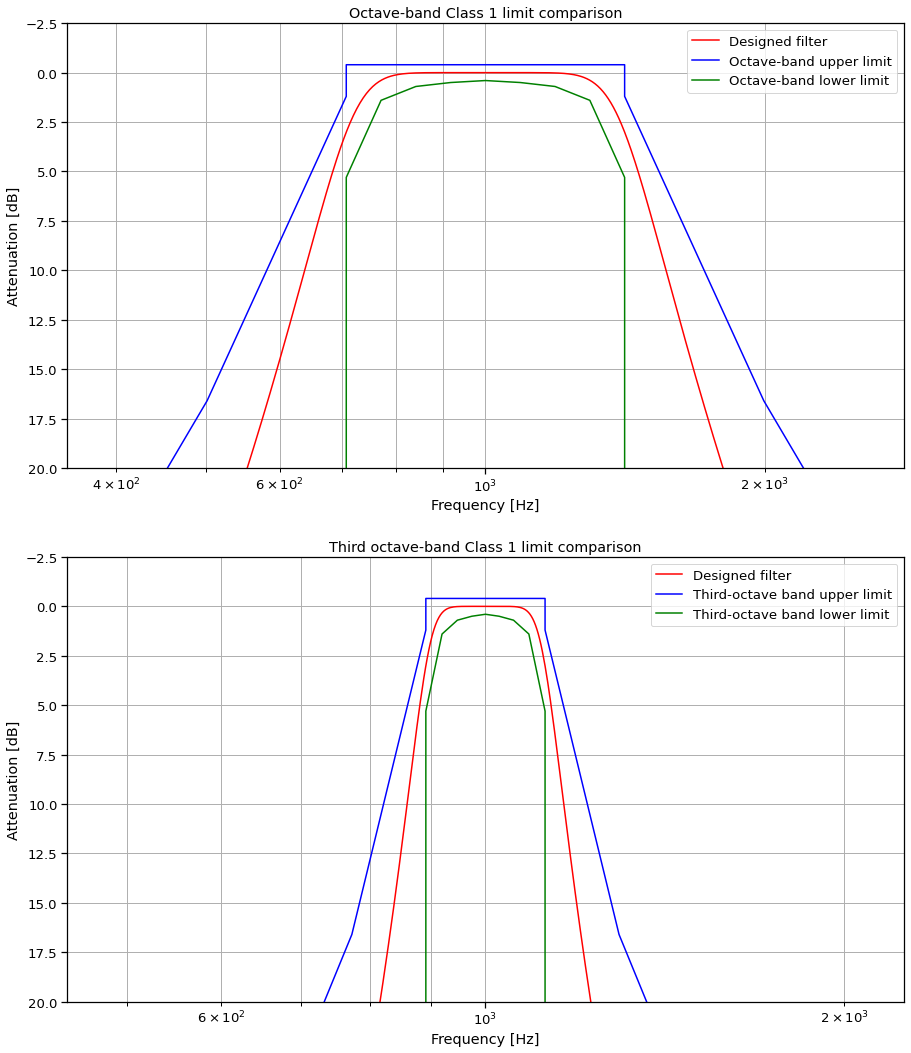

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(15,18))

# 1 kHz octave and third-octave indexes

# 1 kHz zzoctave filter response
w_oct, h_oct = sosfreqz(sos_bp(foct_1[6], foct_2[6]), worN=2**13)  

# 1 kHz third-octave filter response
w_to, h_to = sosfreqz(sos_bp(fto_1[19], fto_2[19]), worN=2**13)  

ax[0].plot((FS*0.5/np.pi)*w_oct, abs(20*np.log10(abs(h_oct+eps))), c='r',
           label='Designed filter')
ax[0].plot(FR*x_t_oct, y_upp, c='b', label='Octave-band upper limit')
ax[0].plot(FR*x_t_oct, y_low, c='g', label='Octave-band lower limit')
    
ax[1].plot((FS*0.5/np.pi)*w_to, abs(20*np.log10(abs(h_to+eps))), c='r', 
           label='Designed filter')
ax[1].plot(FR*x_t_to, y_upp, c='b', label='Third-octave band upper limit')
ax[1].plot(FR*x_t_to, y_low, c='g', label='Third-octave band lower limit')

for ax_ in ax:
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Frequency [Hz]')
    ax_.set_ylabel('Attenuation [dB]')
    ax_.set_ylim([20, -2.5])
    
ax[0].set_title('Octave-band Class 1 limit comparison')
ax[1].set_title('Third octave-band Class 1 limit comparison')

ax[0].set_xlim([foct_1[6]/2, foct_2[6]*2])
ax[1].set_xlim([fto_1[19]/2, fto_2[19]*2]);

## Conclusions



Awesome! As we can see in the image above (and can easily test for all the other filters in the frequency bank), **our filters comply with the Class 1 specifications of the IEC 61260 standard**.

In this notebook we were able to **create a comprehensive octave and third-octave frequency bank in the digital domain**. This will enable us to **provide detail acoustic measurements by providing both a global sound pressure level value, as well as discriminating the level by frequency band**.